In [45]:
# load in required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import shap
import re
import matplotlib.pyplot as plt
import pickle
import os

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France','Germany','Madrid_Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany','Spain_Austria','France','Germany']

city='Germany_other'

if city=='Germany_other':
    city0='Dresden'
    df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
    print(len(df0.columns), 'columns in the data for ', city0)
    df0['City']=city0
    df_all=df0.copy()

    cities0=['Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
    for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
        print(len(df1.columns), 'columns in the data for ', city1)
        df1['City']=city1
        if len(df1.columns==df_all.columns):
            df_all=pd.concat([df_all,df1])
            print(city1, 'added.')
            print(len(df_all), 'rows in the combined dataframe')
    df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
    # df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
    # df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
    df=df_all.copy()
elif city=='France_other':
    city0='Clermont'
    df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
    print(len(df0.columns), 'columns in the data for ', city0)
    df0['City']=city0
    df_all=df0.copy()

    cities0=['Toulouse']
    for city1 in cities0:
        print(city1)
        df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
        print(len(df1.columns), 'columns in the data for ', city1)
        df1['City']=city1
        if len(df1.columns==df_all.columns):
            df_all=pd.concat([df_all,df1])
            print(city1, 'added.')
            print(len(df_all), 'rows in the combined dataframe')
    df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
    # df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
    # df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
    df=df_all.copy()
else: df=pd.read_csv('../outputs/Combined/' + city + '_co_UF.csv')


df=df.loc[:,( 'HHNR','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
'HHSize','IncomeDetailed_Numeric','HHType_simp','maxAgeHH',# household details, omit  'IncomeDetailed', 'HHType', 
'UniversityEducation', 'InEmployment', 'AllRetired', # personal-based details
'UrbPopDensity', 'UrbBuildDensity','DistSubcenter', 'DistCenter', 
'bike_lane_share', 'IntersecDensity', 'street_length', 'LU_UrbFab', 'LU_Comm', 
# target: car ownership
'CarOwnershipHH')
]

df.loc[df['HHType_simp'].isin(['Single_Female_Parent','Single_Male_Parent']),'HHType_simp']='Single_Parent'
df=df.loc[df['UrbPopDensity']<80000,]   
# remove high building density outliers (For Leipzig)
df=df.loc[df['UrbBuildDensity']<1e8,]   
df=df.loc[df['maxAgeHH']>0,]  
df.dropna(inplace=True)

# identify the feature columns
N_non_feature=2 # how many non-features are at the start of the df
cols=df.columns
newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureO' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
# change column names
df.set_axis(newcols,axis=1,inplace=True)
df = df.reset_index(drop=True)

# convert  all categorical variables to dummies
df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureO" in col]]
for col in df_Cat:
    dum=pd.get_dummies(df[[col]])
    df = pd.concat([df, dum], axis = 1)
    # remove the original categorical columns
df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
# HPO with full dataset, grouping by individual person
target = 'CarOwnershipHH'

X=df[[col for col in df.columns if "FeatureO" in col]]
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]

38 columns in the data for  Dresden
Leipzig
38 columns in the data for  Leipzig
Leipzig added.
3117 rows in the combined dataframe
Magdeburg
38 columns in the data for  Magdeburg
Magdeburg added.
4552 rows in the combined dataframe
Potsdam
38 columns in the data for  Potsdam
Potsdam added.
5456 rows in the combined dataframe
Frankfurt am Main
38 columns in the data for  Frankfurt am Main
Frankfurt am Main added.
6352 rows in the combined dataframe
Düsseldorf
38 columns in the data for  Düsseldorf
Düsseldorf added.
9987 rows in the combined dataframe
Kassel
38 columns in the data for  Kassel
Kassel added.
11327 rows in the combined dataframe


In [46]:
fp='../outputs/ML_Results/shap/carown/' + city + '.pkl'
with open(fp, 'rb') as f:
    shap_values=pickle.load(f)

col_dict= {'DistCenter':'Dist. to city center','IntersecDensity':'Instersection density','street_length':'Avg. street length',
            'UniversityEducation':'University education','AllRetired':'Retired','StreetsPerNode':'Streets per node',
       'UrbBuildDensity':'Built-up density','UrbPopDensity':'Population density', 'DistSubcenter':'Dist. to subcenter',
       'bike_lane_share':'Cycle lane share',
       'LU_Urban':'Urban share, land-use','LU_UrbFab':'Urban fabric share, land-use','LU_Comm':'Commercial share, land-use',
       'IncomeDetailed_Numeric':'Income','HHSize':'Household size','maxAgeHH':'Max householder age','InEmployment':'Employed',
       'HHType_simp_Single_Female':'Single female household','HHType_simp_MultiAdult':'Multi-adult household','HHType_simp_MultiAdult_Kids':'Multi-adult household with kids',
       'HHType_simp_Single_Parent':'Single parent household'}
X_lab=[*map(col_dict.get, X_disp)]

Text(0.5, 28.5, 'SHAP (probability of car ownership)')

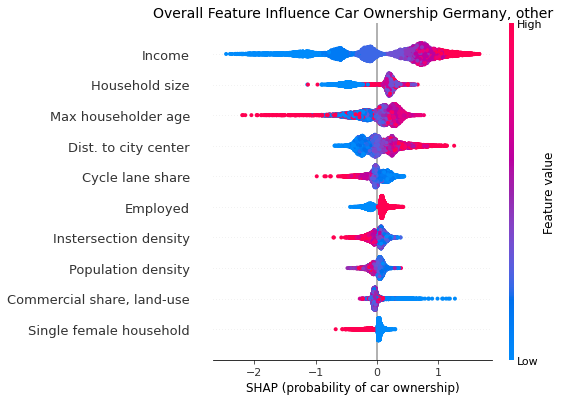

In [47]:
shap.summary_plot(shap_values.sort_index().to_numpy(), X.sort_index(),feature_names=X_lab,max_display=10,show=False)
plt.title('Overall Feature Influence Car Ownership ' + city.replace('_',', '), size=14)
plt.xlabel("SHAP (probability of car ownership)", size=12)
#plt.savefig('../outputs/ML_Results/result_figures/carown/' + city + '_FI_small.png',facecolor='w',dpi=65,bbox_inches='tight')

In [48]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_disp, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

In [38]:
# importance_df=importance_df.loc[importance_df['column_name'].isin(['IncomeDetailed_Numeric','maxAgeHH','UrbPopDensity','UrbBuildDensity','StreetsPerNode','HHSize']),]
# importance_df

In [49]:
# lab_dict= {'DistCenter':'Dist. to city center (km)','IntersecDensity':'Instersection density','StreetLength':'Avg. street length','StreetsPerNode':'Streets per node',
#        'UrbBuildDensity':'Built-up density','UrbPopDensity':'Population density', 'DistSubcenter':'Dist. to subcenter','LU_Urban':'Urban share, land-use',
#        'IncomeDetailed_Numeric':'Income','HHSize':'Household size','maxAgeHH':'Max householder age','InEmployment':'Employed'}

#importance_df['column_label']=importance_df['column_name'].map(lab_dict)
importance_df['column_label']=importance_df['column_name'].map(col_dict)


In [50]:
importance_df

,column_name,shap_importance,column_label
1,IncomeDetailed_Numeric,0.739469,Income
0,HHSize,0.296119,Household size
2,maxAgeHH,0.258891,Max householder age
9,DistCenter,0.233006,Dist. to city center
10,bike_lane_share,0.121353,Cycle lane share
4,InEmployment,0.115962,Employed
11,IntersecDensity,0.09796,Instersection density
6,UrbPopDensity,0.075872,Population density
14,LU_Comm,0.072326,"Commercial share, land-use"
18,HHType_simp_Single_Female,0.071557,Single female household


In [51]:
n=importance_df[:10].index
n

Int64Index([1, 0, 2, 9, 10, 4, 11, 6, 14, 18], dtype='int64')

In [52]:
n=importance_df[:10].index

shap_values.sort_index(inplace=True)
X.sort_index(inplace=True)
data=X.sort_index().iloc[:,n]
values=shap_values.sort_index().iloc[:,n]

xl=[]
yl=[]
y0=[]
#i=0
for i in range(len(n)):
    dftemp=pd.DataFrame({'d':data.iloc[:,i],'v':values.iloc[:,i]})
    dftemp=dftemp.groupby('d')['v'].mean().reset_index()
    dftemp['v0']=0
    xl.append(dftemp['d'].values)
    yl.append(dftemp['v'].values)
    y0.append(dftemp['v0'].values)

city_dict={'Berlin':'Berlin','Paris':'Paris','Germany_other':'Germany, other','France_other':'France, other'}
citylab=city_dict[city]
citylab

'Germany, other'

Text(0, 0.5, 'SHAP (car ownership probability)')

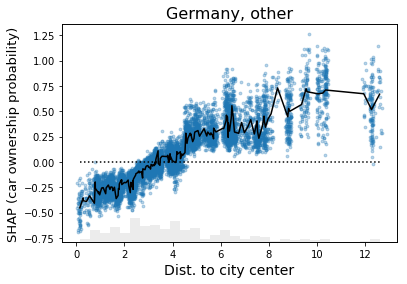

In [54]:
fig = plt.figure()
i=data.columns.get_loc('FeatureO_DistCenter')
ax1 = fig.add_subplot(111) 
xs=data.iloc[:,i]
ys=values.iloc[:,i]

x=xl[i]
y1=y0[i]
y2=yl[i]
xlab=importance_df['column_label'].iloc[i]

ax1.scatter(xs+np.random.normal(0, 0.05, len(data)),ys,alpha=0.3,s=8)
#ax1.scatter(xs,ys,alpha=0.3,s=8)
plt.plot(x,y1,'k:',label='zero')
plt.plot(x,y2,'k',label='mean')
#plt.legend(loc="upper left",prop={'size':12})
if i%2==0:
    ax1.set_ylabel('SHAP value',size=13)
else:
    ax1.set_ylabel('')
ax1.set_xlabel(xlab,size=14)


ax2 = ax1.twinx() 
if len(xs.unique())==2:
    ax2.hist(xs,bins=[-0.5,0.5,1.5], align='mid',color='gray',alpha=0.15)
    ax2.set_xticks([-.5,0,0.5,1,1.5])
else:
    ax2.hist(xs,bins=30,color='gray',alpha=0.15)
    ax2.set_ylim(0,len(data))
ax2.set_yticks([])
plt.title(citylab,fontsize=16)
ax1.set_ylabel('SHAP (car ownership probability)',size=13)
#plt.savefig('../outputs/ML_Results/result_figures/carown/' + city + '_d2c.png',facecolor='w',dpi=65,bbox_inches='tight')

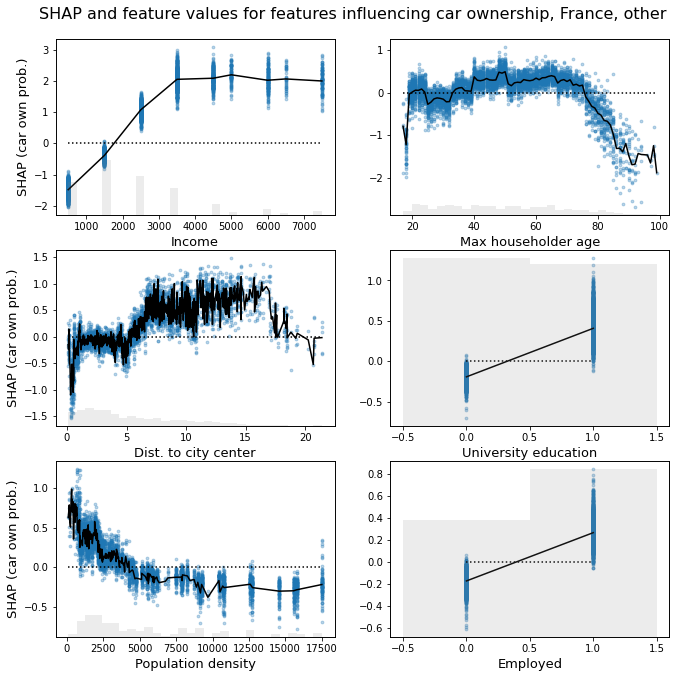

In [44]:
fig = plt.figure(figsize=(11,11))
#ax1 = fig.add_subplot(321)
i=0
for i in range(0,6):
    ax1 = fig.add_subplot(321+i)
    xs=data.iloc[:,i]
    ys=values.iloc[:,i]
    x=xl[i]
    y1=y0[i]
    y2=yl[i]
    xlab=importance_df['column_label'].iloc[i]

    ax1.scatter(xs,ys,alpha=0.3,s=8)
    plt.plot(x,y1,'k:',label='zero')
    plt.plot(x,y2,'k',label='mean')
    #plt.legend(loc="upper left",prop={'size':12})
    if i%2==0:
        ax1.set_ylabel('SHAP (car own prob.)',size=13)
    else:
        ax1.set_ylabel('')
    ax1.set_xlabel(xlab,size=13)


    ax2 = ax1.twinx() 
    if len(xs.unique())==2:
        ax2.hist(xs,bins=[-0.5,0.5,1.5], align='mid',color='gray',alpha=0.15)
        ax2.set_xticks([-.5,0,0.5,1,1.5])
    else:
        ax2.hist(xs,bins=30,color='gray',alpha=0.15)
        ax2.set_ylim(0,len(data))
    ax2.set_yticks([])

    # if i==0:
    #     plt.title('overarching title')
plt.suptitle("SHAP and feature values for features influencing car ownership, " + city.replace('_',', '),y=0.92,size=16)
plt.savefig('../outputs/ML_Results/result_figures/carown/' + city + '_FI_detail6.png',facecolor='w',dpi=65,bbox_inches='tight')